In [ ]:
#pip install ultralytics

In [ ]:
import os
import io
from PIL import Image
from google.colab import files
from google.colab import drive
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import time
from IPython.display import display

In [ ]:
path_yolo_model =  "yolo11n_model_1_float16.tflite"

Mounted at /content/drive


In [ ]:
# Load and display the first image

def select_image(p_uploaded):
  for file_name in p_uploaded.keys():
    image = Image.open(io.BytesIO(p_uploaded[file_name])).convert("RGB")
    #image.show()
    image_resized = image.resize((640, 640))  # or your model input size
    break  # Handle only the first file

  return image_resized

def predict_img_tflite(p_path_nms_model,p_image,p_th,p_boxes):
  tf_interpreter = tf.lite.Interpreter(model_path=p_path_nms_model)
  tf_interpreter.allocate_tensors()
  tf_in_details = tf_interpreter.get_input_details()
  tf_out_details = tf_interpreter.get_output_details()
  # Model expects 640x640 input (assumed) Because model.export(format="tflite") --> 640 by default
  tf_image_width = tf_in_details[0]['shape'][2]
  tf_image_height = tf_in_details[0]['shape'][1]
  # tf_image = Image.open(p_path_image).convert("RGB")
  # tf_image_resized = tf_image.resize((tf_image_width, tf_image_height))
  tf_image_resized = p_image.copy()
  tf_image_np = np.array(tf_image_resized, dtype=np.float32) / 255.0
  tf_image_np = np.expand_dims(tf_image_np, axis=0)
  print(f"Image to be processed:{tf_image_np.shape}")

  #Run inference or prediction
  tf_interpreter.set_tensor(tf_in_details[0]['index'], tf_image_np)
  tf_start = time.time()
  tf_interpreter.invoke()
  print(f"Prediction time: {time.time() - tf_start:.2f}s")

  # Get predictions from NMS model
  tf_output = tf_interpreter.get_tensor(tf_out_details[0]['index'])[0]  # shape: [300, 6]
  print(f"Output shape: {tf_output.shape}")
  tf_draw = ImageDraw.Draw(tf_image_resized)
  tf_threshold = p_th
  for det in tf_output:
    x1, y1, x2, y2, score, cls = det
    if score >= tf_threshold:
        x1 = int(x1 * tf_image_width)  #To get the coordinate to the image shape 640x640
        y1 = int(y1 * tf_image_height)
        x2 = int(x2 * tf_image_width)
        y2 = int(y2 * tf_image_height)
        if p_boxes:
          print(f"Score:{score:.2f},Box:{x1,y1,x2,y2}")
        tf_draw.rectangle([x1, y1, x2, y2], outline="blue", width=3)
        tf_draw.text((x1, y1), f"Class {int(cls)}: {score:.2f}", fill="red")

  plt.imshow(tf_image_resized)

In [ ]:
#Uploading
uploaded = files.upload()

Saving monstera-leaves-start-splitting.jpg to monstera-leaves-start-splitting.jpg


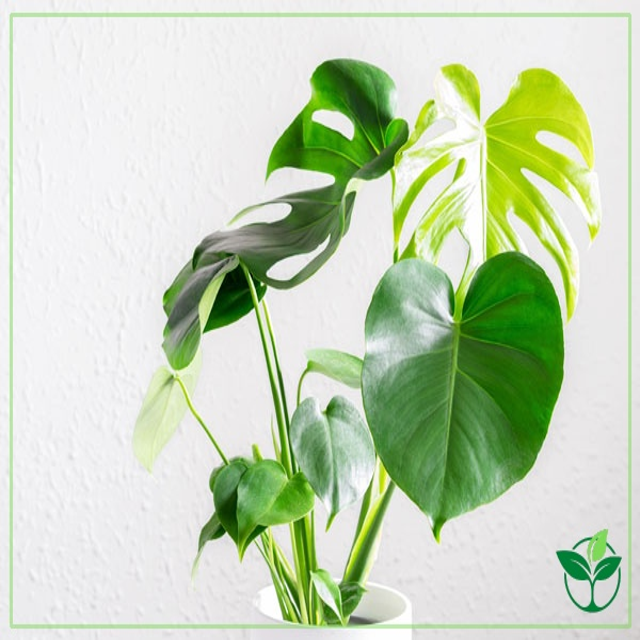

In [ ]:
#Selecting Image
sel_img = select_image(uploaded)
display(sel_img)

Image to be processed:(1, 640, 640, 3)
Prediction time: 0.16s
Output shape: (300, 6)
Score:0.91,Box:(359, 251, 565, 547)


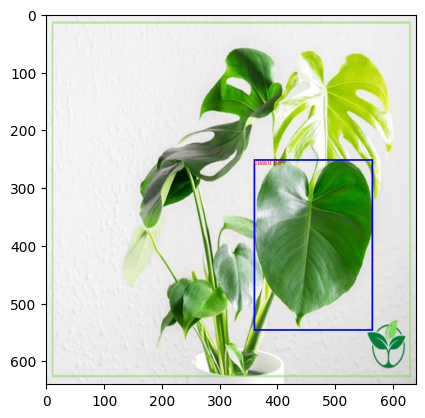

In [ ]:
predict_img_tflite(path_yolo_model,sel_img,0.6,True)

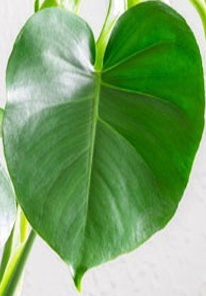

In [ ]:
from PIL import Image


sel_img.crop((359, 251, 565, 547))